In [1]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import pandas as pd

Using TensorFlow backend.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cv2
import scipy
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [3]:
import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input, Softmax
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import LeakyReLU

In [171]:
image_gen = ImageDataGenerator(validation_split=0.15, rescale=1.0/255.0, width_shift_range=4, height_shift_range=4)
dataframe = pd.read_csv("../assets/data/bonuses/labels.txt", delim_whitespace=True)
input_shape = (15, 22)

In [172]:
categories = {}
for i, data in dataframe.iterrows():
    filename, category = data
    categories.setdefault(category, 0)
    categories[category] += 1

In [173]:
categories

{'1X': 3575, '2L': 575, '2W': 450, '3L': 525, '3W': 75}

In [174]:
training_generator = image_gen.flow_from_dataframe(
    dataframe=dataframe, 
    directory="../assets/data/bonuses/",
    x_col="filename",
    y_col="category",
    subset="training",
    batch_size=20,
    classes=None,
    class_mode="categorical",
    shuffle=True,
    target_size=input_shape
)

Found 4420 validated image filenames belonging to 5 classes.


In [175]:
training_generator.class_indices

{'1X': 0, '2L': 1, '2W': 2, '3L': 3, '3W': 4}

In [152]:
validation_generator = image_gen.flow_from_dataframe(
    dataframe=dataframe, 
    directory="../assets/data/bonuses/",
    x_col="filename",
    y_col="category",
    subset="validation",
    batch_size=20,
    classes=None,
    class_mode="categorical",
    shuffle=True,
    target_size=input_shape
)

Found 780 validated image filenames belonging to 5 classes.


In [176]:
validation_generator.class_indices

{'1X': 0, '2L': 1, '2W': 2, '3L': 3, '3W': 4}

In [177]:
alpha = 0.2

inputs = Input(shape=input_shape+(3,))

x = Conv2D(8, (3, 3))(inputs)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(16, (3, 3))(inputs)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3))(x)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

x = Dense(32)(x)
x = LeakyReLU(alpha)(x)

x = Dense(16)(x)
x = LeakyReLU(alpha)(x)

x = Dense(5, activation="softmax")(x)
outputs = x

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [178]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 15, 22, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 20, 16)        448       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 13, 20, 16)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 10, 16)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 8, 32)          4640      
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 4, 8, 32)          0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 2, 4, 32)          0   

In [179]:
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

model.fit_generator(
    generator=training_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,
)

Epoch 1/10
221/221 [==============================] - 4s 20ms/step - loss: 1.0207 - accuracy: 0.6776 - val_loss: 0.9399 - val_accuracy: 0.7436
Epoch 2/10
221/221 [==============================] - 4s 20ms/step - loss: 0.7294 - accuracy: 0.6808 - val_loss: 0.3966 - val_accuracy: 0.7603
Epoch 3/10
221/221 [==============================] - 4s 19ms/step - loss: 0.2339 - accuracy: 0.9647 - val_loss: 0.0652 - val_accuracy: 0.9679
Epoch 4/10
221/221 [==============================] - 4s 20ms/step - loss: 0.0662 - accuracy: 0.9887 - val_loss: 0.1022 - val_accuracy: 0.9679
Epoch 5/10
221/221 [==============================] - 4s 19ms/step - loss: 0.0281 - accuracy: 0.9930 - val_loss: 0.0460 - val_accuracy: 1.0000
Epoch 6/10
221/221 [==============================] - 4s 19ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 7/10
221/221 [==============================] - 4s 20ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 1.0000

In [186]:
model.save("bonuses.h5")

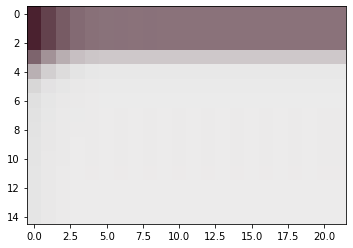

In [183]:
batch = 0
index = 0
plt.imshow(validation_generator[batch][index][0])
plt.show()

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
[0 4]


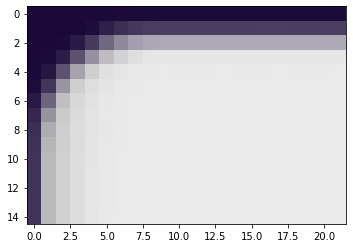

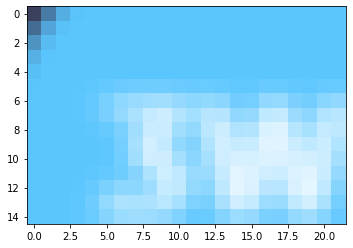

In [187]:
other_image = cv2.imread("../assets/data/bonuses/sample_0.png")
image = cv2.imread("../assets/data/bonuses/sample_4225.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
data = np.array([other_image, image])
prediction = model.predict(data)
print(prediction)
print(np.argmax(prediction, axis=1))

# {'1X': 0, '2L': 1, '2W': 2, '3L': 3, '3W': 4}

plt.imshow(other_image)
plt.show()
plt.imshow(image)
plt.show()